In [1]:
# General import 

import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt

In [2]:
# pyMPC import

from pyMPC.mpc import MPCController

## System dynamics ##

Point mass $M=2\; \text{Kg}$ subject to an input force $F_{ext}$ and viscous friction with coefficient $b = 0.3\;N \cdot \frac{s}{m}$.

\begin{equation}
\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{M}v + \frac{1}{M}F_{ext}
\end{split}
\end{equation}

System equations discretized with sampling time $T_s = 0.2~\text{s}$.


In [3]:
# MPC system matrices #

Ts = 0.2 # sampling time (s)
M = 2    # mass (Kg)
b = 0.3  # friction coefficient (N*s/m)

# MPC model dynamics: x_k+1 = Ad*x_k + Bb*u_k
Ad = sparse.csc_matrix([
    [1.0, Ts],
    [0,  1.0 -b/M*Ts]
])
Bd = sparse.csc_matrix([
  [0.0],
  [Ts/M]])

# Continous-time system matrices (just for reference, not used)
Ac = np.array([
    [0.0, 1.0],
    [0, -b/M]]
)
Bc = np.array([
    [0.0],
    [1/M]
])

In [4]:
# MPC reference input and states (set-points)

pref = 7.0
vref = 0.0
xref = np.array([pref, vref]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

In [5]:
# MPC constraints

xmin = np.array([-100.0, -100.0])
xmax = np.array([100.0,   100.0])

umin = np.array([-1.2])
umax = np.array([1.2])

# Constraints input variation with respect to previous sample
Dumin = np.array([-2e-1]) 
Dumax = np.array([2e-1])

# MPC objective function weights
Qx = sparse.diags([0.5, 0.1])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.5, 0.1])  # Quadratic cost for xN
Qu = 2.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 10.0 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

In [6]:
# Initial state
x0 = np.array([0.1, 0.2]) # initial state

# Prediction horizon
Np = 20


In [7]:
# Initialize and setup MPC controller

K = MPCController(Ad,Bd,Np=Np, x0=x0,xref=xref,uminus1=uminus1,
                  Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
                  xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax)
K.setup() # this initializes the QP problem for the first step

C:\Users\marco\Anaconda3\envs\RL\lib\site-packages\osqp\interface.py:109: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")


In [8]:
# Simulate in closed loop. Use MPC model as real system

[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 20 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
usim = np.zeros((nsim,nu))
tsim = np.arange(0,nsim)*Ts

time_start = time.time()

xstep = x0
uMPC = uminus1
for i in range(nsim):
    xsim[i,:] = xstep

    # MPC update and step. Could be in just one function call
    K.update(xstep, uMPC) # update with measurement
    uMPC = K.output() # MPC step (u_k value)
    usim[i,:] = uMPC

    xstep = Ad.dot(xstep) + Bd.dot(uMPC)  # Real system step (x_k+1 value)

time_sim = time.time() - time_start


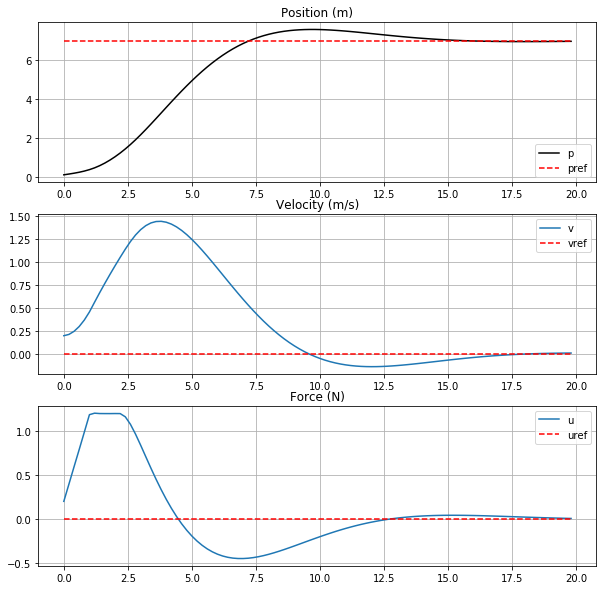

In [9]:
# Plot results

fig,axes = plt.subplots(3,1, figsize=(10,10))
axes[0].plot(tsim, xsim[:,0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="pref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:,1], label="v")
axes[1].plot(tsim, xref[1]*np.ones(np.shape(tsim)), "r--", label="vref")
axes[1].set_title("Velocity (m/s)")

axes[2].plot(tsim, usim[:,0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="uref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()